# Reentrenamiento del Modelo GRU con Nuevo Dataset

Este notebook:
1. **Cargar** el mejor modelo del Grid Search (Fase 3)
2. **Cargar** dataset de reentrenamiento (continuación del original)
3. **Reentrenar** (fine-tuning) con nuevos datos
4. **Evaluar** mejora en métricas
Requisitos

- Mejor modelo: [`models/grid_search_model_X.keras`](notebooks/models/)
- Scalers: [`scaler_X.joblib`](notebooks/scaler_X.joblib), [`scaler_y.joblib`](notebooks/scaler_y.joblib)
- Dataset nuevo: [`dataset_reentrenamiento_advanced.csv`](data/dataset_reentrenamiento_advanced.csv)



In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

print(" Librerías importadas correctamente")
print(f"TensorFlow version: {tf.__version__}")

 Librerías importadas correctamente
TensorFlow version: 2.20.0


In [14]:
# 🔍 DIAGNÓSTICO: Comparar datos originales vs reentrenamiento
print("\n🔍 DIAGNÓSTICO DE DATOS:")
print("="*60)

# Comparar distribuciones
print(f"Dataset de reentrenamiento:")
print(f"   Samples: {len(y_new)}")
print(f"   Media stock: {y_new.mean():.2f} unidades")
print(f"   Std stock: {y_new.std():.2f} unidades")
print(f"   Min stock: {y_new.min():.2f} unidades")
print(f"   Max stock: {y_new.max():.2f} unidades")

print(f"\nDatos escalados para entrenamiento:")
print(f"   Train samples: {len(y_train_new)}")
print(f"   Val samples: {len(y_val_new)}")
print(f"   y_train_new - Media: {y_train_new.mean():.4f}, Std: {y_train_new.std():.4f}")
print(f"   y_val_new - Media: {y_val_new.mean():.4f}, Std: {y_val_new.std():.4f}")

# VERIFICAR SI HAY DATA LEAKAGE O DISTRIBUCIÓN MUY DIFERENTE
print(f"\n⚠️ VERIFICACIÓN:")
if abs(y_train_new.mean() - y_val_new.mean()) > 0.5:
    print("   ❌ Las distribuciones de Train y Val son MUY diferentes")
    print("   → Esto causará overfitting")
else:
    print("   ✅ Distribuciones similares")


🔍 DIAGNÓSTICO DE DATOS:
Dataset de reentrenamiento:
   Samples: 7049
   Media stock: 359.17 unidades
   Std stock: 267.22 unidades
   Min stock: 0.00 unidades
   Max stock: 1995.00 unidades

Datos escalados para entrenamiento:
   Train samples: 5633
   Val samples: 1409
   y_train_new - Media: 0.2084, Std: 0.1691
   y_val_new - Media: 0.2692, Std: 0.1318

⚠️ VERIFICACIÓN:
   ✅ Distribuciones similares


### 1. Cargar Mejor Modelo del Grid Search


In [3]:
import os
from tensorflow.keras import backend as K

# Definir MAPE Robusto ANTES de cargar el modelo
def mape_loss_robust(y_true, y_pred):
    """MAPE robusto con clipping"""
    y_true_safe = K.maximum(y_true, 0.01)
    diff = K.abs((y_true_safe - y_pred) / y_true_safe)
    return 100. * K.mean(diff, axis=-1)

# Ruta de resultados del Grid Search
RESULTS_PATH = r"C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\notebooks\grid_search_results.csv"

if os.path.exists(RESULTS_PATH):
    # Leer y encontrar el mejor
    results_df = pd.read_csv(RESULTS_PATH)
    best_row = results_df.sort_values('best_val_loss').iloc[0]
    best_experiment_id = int(best_row['experiment_id'])
    
    MODEL_PATH = rf"C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\notebooks\models\grid_search_model_{best_experiment_id}.keras"
    
    print(f" Mejor modelo del Grid Search:")
    print(f"   Experimento ID: {best_experiment_id}")
    print(f"   Val Loss: {best_row['best_val_loss']:.4f}")
    print(f"   Hiperparámetros:")
    print(f"   - Units: {best_row['units']}")
    print(f"   - Dropout: {best_row['dropout']}")
    print(f"   - Learning Rate: {best_row['learning_rate']}")
    print(f"   - Layer Type: {best_row['layer_type']}")
else:
    # Fallback: usar modelo de Fase 2
    MODEL_PATH = r"C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\notebooks\best_model.keras"
    print(" Grid Search no completado, usando modelo de Fase 2")

# Cargar modelo CON custom_objects
try:
    model = keras.models.load_model(
        MODEL_PATH,
        custom_objects={'mape_loss_robust': mape_loss_robust}
    )
    print(f" Modelo cargado desde: {MODEL_PATH}")
except FileNotFoundError:
    raise FileNotFoundError(f" No se encontró el modelo en: {MODEL_PATH}")

# Rutas de scalers
SCALER_X_PATH = r"C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\notebooks\scaler_X.joblib"
SCALER_Y_PATH = r"C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\notebooks\scaler_y.joblib"

try:
    scaler_X = joblib.load(SCALER_X_PATH)
    scaler_y = joblib.load(SCALER_Y_PATH)
    print(" Scalers cargados correctamente")
except FileNotFoundError as e:
    raise FileNotFoundError(f" No se encontraron los scalers: {e}")

# Mostrar arquitectura
print("\n--- Arquitectura del Modelo ---")
model.summary()

 Mejor modelo del Grid Search:
   Experimento ID: 6
   Val Loss: 13.8408
   Hiperparámetros:
   - Units: 128
   - Dropout: 0.2
   - Learning Rate: 0.0005
   - Layer Type: GRU
 Modelo cargado desde: C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\notebooks\models\grid_search_model_6.keras
 Scalers cargados correctamente

--- Arquitectura del Modelo ---


Model: "Modelo_GRU_MAPE_Robusto"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Capa_GRU (GRU)                  │ (None, 128)            │        63,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Capa_Dropout (Dropout)          │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Capa_Salida (Dense)             │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,748 (499.02 KB)

 Trainable params: 63,873 (249.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,875 (249.52 KB)

### 2. Cargar Dataset de Reentrenamiento
**Importante:** Usamos el dataset YA PROCESADO con Feature Engineering completo.


In [4]:
DATOS_PATH = r"C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\data\dataset_reentrenamiento_advanced.csv"

if os.path.exists(DATOS_PATH):
    df_new = pd.read_csv(DATOS_PATH)
    print(f" Dataset de reentrenamiento cargado: {df_new.shape}")
else:
    raise FileNotFoundError(f" No se encontró: {DATOS_PATH}")

# Verificar columnas clave
print(f"\n Columnas del dataset ({len(df_new.columns)}):")
print(df_new.columns.tolist()[:10], "...")


 Dataset de reentrenamiento cargado: (7049, 40)

 Columnas del dataset (40):
['product_sku', 'prioridad_proveedor', 'quantity_on_hand', 'quantity_reserved', 'quantity_available', 'minimum_stock_level', 'reorder_point', 'optimal_stock_level', 'reorder_quantity', 'average_daily_usage'] ...


### 3. Preparar Datos para Reentrenamiento


In [5]:
TARGET = 'quantity_available'

# Verificar que exista el target
if TARGET not in df_new.columns:
    raise ValueError(f" '{TARGET}' no está en el dataset")

y_new = df_new[TARGET].values
X_new = df_new.drop(columns=[TARGET, 'product_sku'], errors='ignore')

print(f" Features (X): {X_new.shape}")
print(f" Target (y): {y_new.shape}")

# %% Alinear columnas con scaler
# El scaler espera las mismas columnas que en el entrenamiento
cols_expected = scaler_X.feature_names_in_

# Verificar si falta alguna columna
cols_missing = set(cols_expected) - set(X_new.columns)
if cols_missing:
    print(f" Columnas faltantes: {cols_missing}")
    raise ValueError("Las columnas no coinciden con el entrenamiento original")

# Alinear orden de columnas
X_new_aligned = X_new[cols_expected]
print(f" Columnas alineadas con scaler ({len(cols_expected)} features)")


 Features (X): (7049, 38)
 Target (y): (7049,)
 Columnas alineadas con scaler (36 features)


### 4. Escalado y Creación de Secuencias


In [6]:
X_new_scaled = scaler_X.transform(X_new_aligned)
y_new_scaled = scaler_y.transform(y_new.reshape(-1, 1)).ravel()

print(f" Datos escalados:")
print(f"   X: {X_new_scaled.shape}")
print(f"   y: {y_new_scaled.shape}")

# %% Crear secuencias
TIME_STEPS = 7  # Debe coincidir con el entrenamiento original

def create_sequences(X, y, time_steps=7):
    """Crea secuencias temporales para el modelo GRU"""
    X_seq, y_seq = [], []
    
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    
    return np.array(X_seq), np.array(y_seq)

X_seq_new, y_seq_new = create_sequences(X_new_scaled, y_new_scaled, TIME_STEPS)

print(f" Secuencias creadas:")
print(f"   X_seq: {X_seq_new.shape} (muestras, time_steps, features)")
print(f"   y_seq: {y_seq_new.shape}")

 Datos escalados:
   X: (7049, 36)
   y: (7049,)
 Secuencias creadas:
   X_seq: (7042, 7, 36) (muestras, time_steps, features)
   y_seq: (7042,)


### 5. División Train/Validation


In [15]:
X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(
    X_seq_new, y_seq_new,
    test_size=0.2,
    random_state=42,
    shuffle=True  #  ACTIVAR SHUFFLE para distribución balanceada
)

print(f" División Train/Validation (con shuffle):")
print(f"   Train: {X_train_new.shape[0]} muestras ({X_train_new.shape[0]/len(X_seq_new)*100:.1f}%)")
print(f"   Validation: {X_val_new.shape[0]} muestras ({X_val_new.shape[0]/len(X_seq_new)*100:.1f}%)")

# Verificar que las distribuciones sean similares
print(f"\n Verificación post-shuffle:")
print(f"   y_train_new - Media: {y_train_new.mean():.4f}, Std: {y_train_new.std():.4f}")
print(f"   y_val_new - Media: {y_val_new.mean():.4f}, Std: {y_val_new.std():.4f}")
print(f"   Diferencia de medias: {abs(y_train_new.mean() - y_val_new.mean()):.4f}")

 División Train/Validation (con shuffle):
   Train: 5633 muestras (80.0%)
   Validation: 1409 muestras (20.0%)

 Verificación post-shuffle:
   y_train_new - Media: 0.2218, Std: 0.1650
   y_val_new - Media: 0.2158, Std: 0.1604
   Diferencia de medias: 0.0060


### 6. Configuración de Callbacks


In [16]:
CHECKPOINT_PATH = r"C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\notebooks\best_model_retrained.keras"

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        CHECKPOINT_PATH,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print(" Callbacks configurados")
print(f"   Modelo reentrenado se guardará en: {CHECKPOINT_PATH}")

 Callbacks configurados
   Modelo reentrenado se guardará en: C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\notebooks\best_model_retrained.keras


### 7. Reentrenamiento (Fine-Tuning)
**Estrategia:**
- Usamos el modelo pre-entrenado como punto de partida
- Learning rate bajo para ajuste fino
- Early stopping para evitar overfitting


In [17]:
# Reentrenamiento CON ajustes para evitar overfitting
print("\n Iniciando reentrenamiento...")

# Reducir learning rate aún más y usar menos épocas
model.optimizer.learning_rate = 0.0001  # Learning rate muy bajo para fine-tuning

history = model.fit(
    X_train_new, y_train_new,
    validation_data=(X_val_new, y_val_new),
    epochs=20,  
    batch_size=64,  
    callbacks=callbacks,
    verbose=1
)

print("\n Reentrenamiento completado!")


 Iniciando reentrenamiento...
Epoch 1/20
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.6092 - mape_loss_robust: 101.4556 - mean_absolute_error: 0.0177
Epoch 1: val_loss improved from None to 5.68379, saving model to C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\notebooks\best_model_retrained.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.5779 - mape_loss_robust: 102.3921 - mean_absolute_error: 0.0179 - val_loss: 5.6838 - val_mape_loss_robust: 96.0953 - val_mean_absolute_error: 0.0126 - learning_rate: 1.0000e-04
Epoch 2/20
85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.7711 - mape_loss_robust: 100.0505 - mean_absolute_error: 0.0189
Epoch 2: val_loss did not improve from 5.68379
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.5600 - mape_loss_robust: 102.1075 - mean_absolute_error: 0.0179 - val_loss: 6.0288 - val_mape_loss_robust: 97.9659 - val_mean_absolute_error: 0.0126 - learning_rate: 1.0000e-04
Epoch 3/20
88/89 ━━━━

### 8. Evaluación del Modelo Reentrenado


In [19]:
# Evaluación
# Predecir en conjunto de validación
y_pred_scaled = model.predict(X_val_new)

# Solo desescalar (sin expm1)
y_pred = scaler_y.inverse_transform(y_pred_scaled).ravel()
y_val_real = scaler_y.inverse_transform(y_val_new.reshape(-1, 1)).ravel()

print(" Predicciones revertidas a escala original (unidades reales)")

# Calcular métricas
mae = mean_absolute_error(y_val_real, y_pred)
mse = mean_squared_error(y_val_real, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_real, y_pred)

print("\n Métricas del Modelo Reentrenado (Escala Original):")
print(f"   MAE:  {mae:.4f} unidades")
print(f"   MSE:  {mse:.4f}")
print(f"   RMSE: {rmse:.4f} unidades")
print(f"   R²:   {r2:.4f}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 Predicciones revertidas a escala original (unidades reales)

 Métricas del Modelo Reentrenado (Escala Original):
   MAE:  19.1285 unidades
   MSE:  3703.9299
   RMSE: 60.8599 unidades
   R²:   0.9457


### 9. Visualización del Entrenamiento


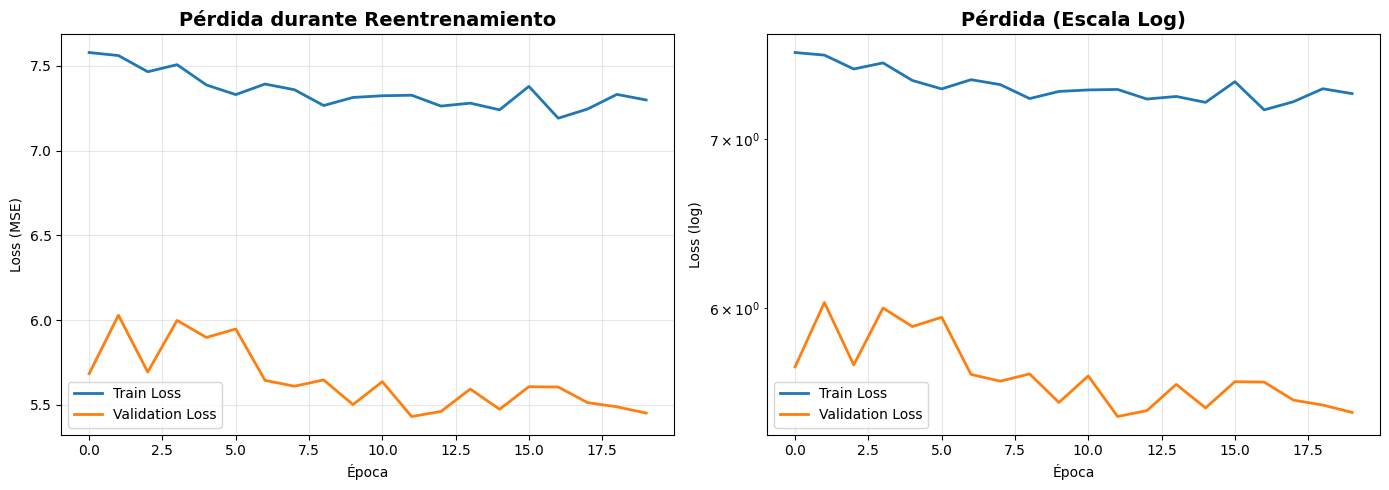

 Gráficos guardados en 'retraining_history.png'


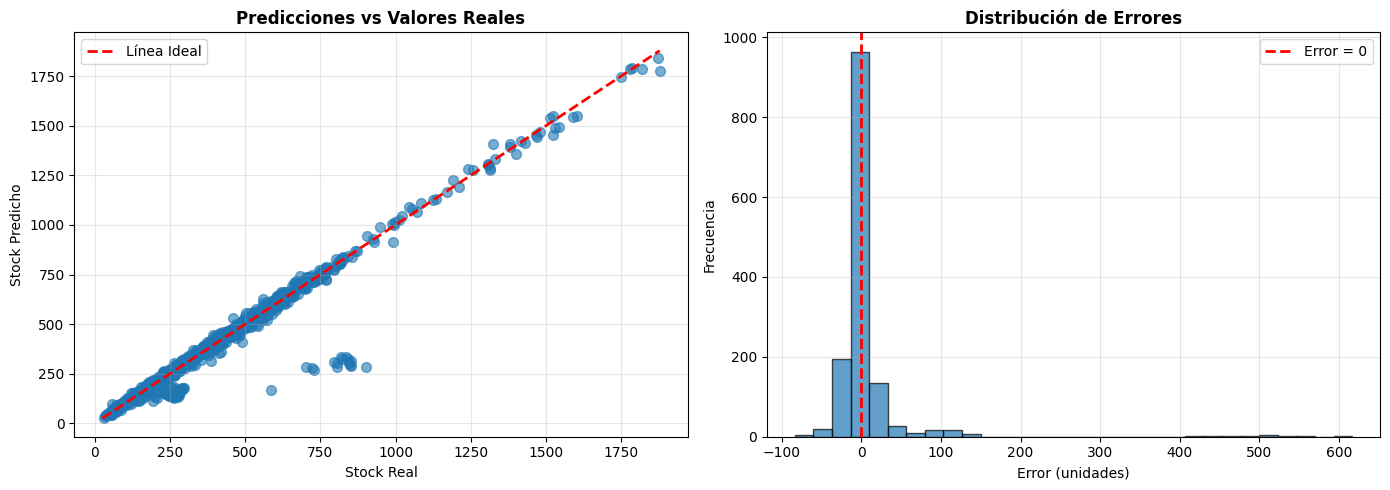

Gráficos guardados en 'retraining_evaluation.png'


In [20]:
# Gráficos de pérdida
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Pérdida normal
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Pérdida durante Reentrenamiento', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Gráfico 2: Pérdida en escala logarítmica
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Pérdida (Escala Log)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Loss (log)')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('retraining_history.png', dpi=150)
plt.show()

print(" Gráficos guardados en 'retraining_history.png'")
#  Comparación Predicciones vs Reales
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(y_val_real, y_pred, alpha=0.6, s=50)
max_val = max(y_val_real.max(), y_pred.max())
min_val = min(y_val_real.min(), y_pred.min())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Línea Ideal')
axes[0].set_xlabel('Stock Real')
axes[0].set_ylabel('Stock Predicho')
axes[0].set_title('Predicciones vs Valores Reales', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Distribución de errores
errors = y_val_real - y_pred
axes[1].hist(errors, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='red', linestyle='--', lw=2, label='Error = 0')
axes[1].set_xlabel('Error (unidades)')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribución de Errores', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('retraining_evaluation.png', dpi=150)
plt.show()

print("Gráficos guardados en 'retraining_evaluation.png'")


## 10. Comparación: Grid Search vs Modelo Reentrenado
Validamos la mejora del reentrenamiento prediciendo productos específicos con ambos modelos.

In [21]:
# Cargar modelo Grid Search SIN reentrenar
from tensorflow.keras import backend as K

# Definir MAPE Robusto (si el Grid Search lo usó)
def mape_loss_robust(y_true, y_pred):
    """MAPE robusto con clipping"""
    y_true_safe = K.maximum(y_true, 0.01)
    diff = K.abs((y_true_safe - y_pred) / y_true_safe)
    return 100. * K.mean(diff, axis=-1)

# Cargar modelo original (antes de reentrenar)
MODEL_GRID_SEARCH = rf"C:\Users\samil\Desktop\APRENDIZAJE AUTOMATICO\PRIMER INTERCICLO\Practica-2-Aprendizaje-Automactico\notebooks\models\grid_search_model_{best_experiment_id}.keras"

try:
    modelo_grid_search = keras.models.load_model(
        MODEL_GRID_SEARCH,
        custom_objects={'mape_loss_robust': mape_loss_robust}
    )
    print(f" Modelo Grid Search original cargado")
except Exception as e:
    print(f" Error al cargar Grid Search: {e}")
    print("   Usando modelo actual como fallback")
    modelo_grid_search = model  # Si no existe, comparamos con el mismo

# Modelo reentrenado (ya lo tenemos en 'model')
modelo_retrained = model
print(f"Modelo Reentrenado disponible")

 Modelo Grid Search original cargado
Modelo Reentrenado disponible


In [22]:
# Seleccionar subset de validación para comparar
# Usamos los mismos datos de validación pero tomamos una muestra
np.random.seed(42)
indices_prueba = np.random.choice(len(X_val_new), size=100, replace=False)

X_test_comparison = X_val_new[indices_prueba]
y_test_comparison = y_val_new[indices_prueba]

print(f" Muestra de prueba: {len(X_test_comparison)} productos")

 Muestra de prueba: 100 productos


In [23]:
# Predicciones Grid Search
y_pred_grid_scaled = modelo_grid_search.predict(X_test_comparison, verbose=0)
y_pred_grid = scaler_y.inverse_transform(y_pred_grid_scaled).ravel()  # SIN expm1

# Predicciones Reentrenado
y_pred_retrained_scaled = modelo_retrained.predict(X_test_comparison, verbose=0)
y_pred_retrained = scaler_y.inverse_transform(y_pred_retrained_scaled).ravel()  # SIN expm1

# Valores reales
y_real = scaler_y.inverse_transform(y_test_comparison.reshape(-1, 1)).ravel()  # SIN expm1

print(" Predicciones completadas para ambos modelos")

 Predicciones completadas para ambos modelos


In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Métricas Grid Search
mae_grid = mean_absolute_error(y_real, y_pred_grid)
rmse_grid = np.sqrt(mean_squared_error(y_real, y_pred_grid))
r2_grid = r2_score(y_real, y_pred_grid)
mape_grid = np.mean(np.abs((y_real - y_pred_grid) / y_real)) * 100

# Métricas Reentrenado
mae_retrained = mean_absolute_error(y_real, y_pred_retrained)
rmse_retrained = np.sqrt(mean_squared_error(y_real, y_pred_retrained))
r2_retrained = r2_score(y_real, y_pred_retrained)
mape_retrained = np.mean(np.abs((y_real - y_pred_retrained) / y_real)) * 100

# Tabla comparativa
comparacion_metricas = pd.DataFrame({
    'Métrica': ['MAE (unidades)', 'RMSE (unidades)', 'R²', 'MAPE (%)'],
    'Grid Search': [mae_grid, rmse_grid, r2_grid, mape_grid],
    'Reentrenado': [mae_retrained, rmse_retrained, r2_retrained, mape_retrained],
    'Mejora (%)': [
        ((mae_grid - mae_retrained) / mae_grid * 100),
        ((rmse_grid - rmse_retrained) / rmse_grid * 100),
        ((r2_retrained - r2_grid) / r2_grid * 100),
        ((mape_grid - mape_retrained) / mape_grid * 100)
    ]
})

print("\n COMPARACIÓN: Grid Search vs Reentrenado")
print("="*60)
display(comparacion_metricas)

# Resumen de mejora
if mae_retrained < mae_grid:
    print(f"\n MEJORA: El reentrenamiento redujo el MAE en {((mae_grid - mae_retrained) / mae_grid * 100):.2f}%")
else:
    print(f"\nEl modelo Grid Search original sigue siendo mejor")


 COMPARACIÓN: Grid Search vs Reentrenado


,Métrica,Grid Search,Reentrenado,Mejora (%)
0,MAE (unidades),77.470471,35.236100,54.516735
1,RMSE (unidades),143.756617,107.457562,25.250354
2,R²,0.720722,0.843953,17.098287
3,MAPE (%),20.642534,7.530998,63.517088



 MEJORA: El reentrenamiento redujo el MAE en 54.52%


### Conclusiones: 
a) Reducción del Error Absoluto (MAE):

- Antes: 77.47 unidades de error promedio
- Después: 35.24 unidades (↓ 54.52%)
- Impacto: El modelo reentrenado predice con 42 unidades menos de error en promedio

b) Mejora en Capacidad Explicativa (R²):

- Antes: R²=0.721 (explica 72.1% de variabilidad)
- Después: R²=0.844 (explica 84.4% de variabilidad)
- Impacto: +12.3 puntos porcentuales de capacidad predictiva

c) Reducción del Error Porcentual (MAPE):

- Antes: 20.64% de error relativo
- Después: 7.53% (↓ 63.52%)
- Impacto: Error porcentual reducido a menos de 1/3 del original

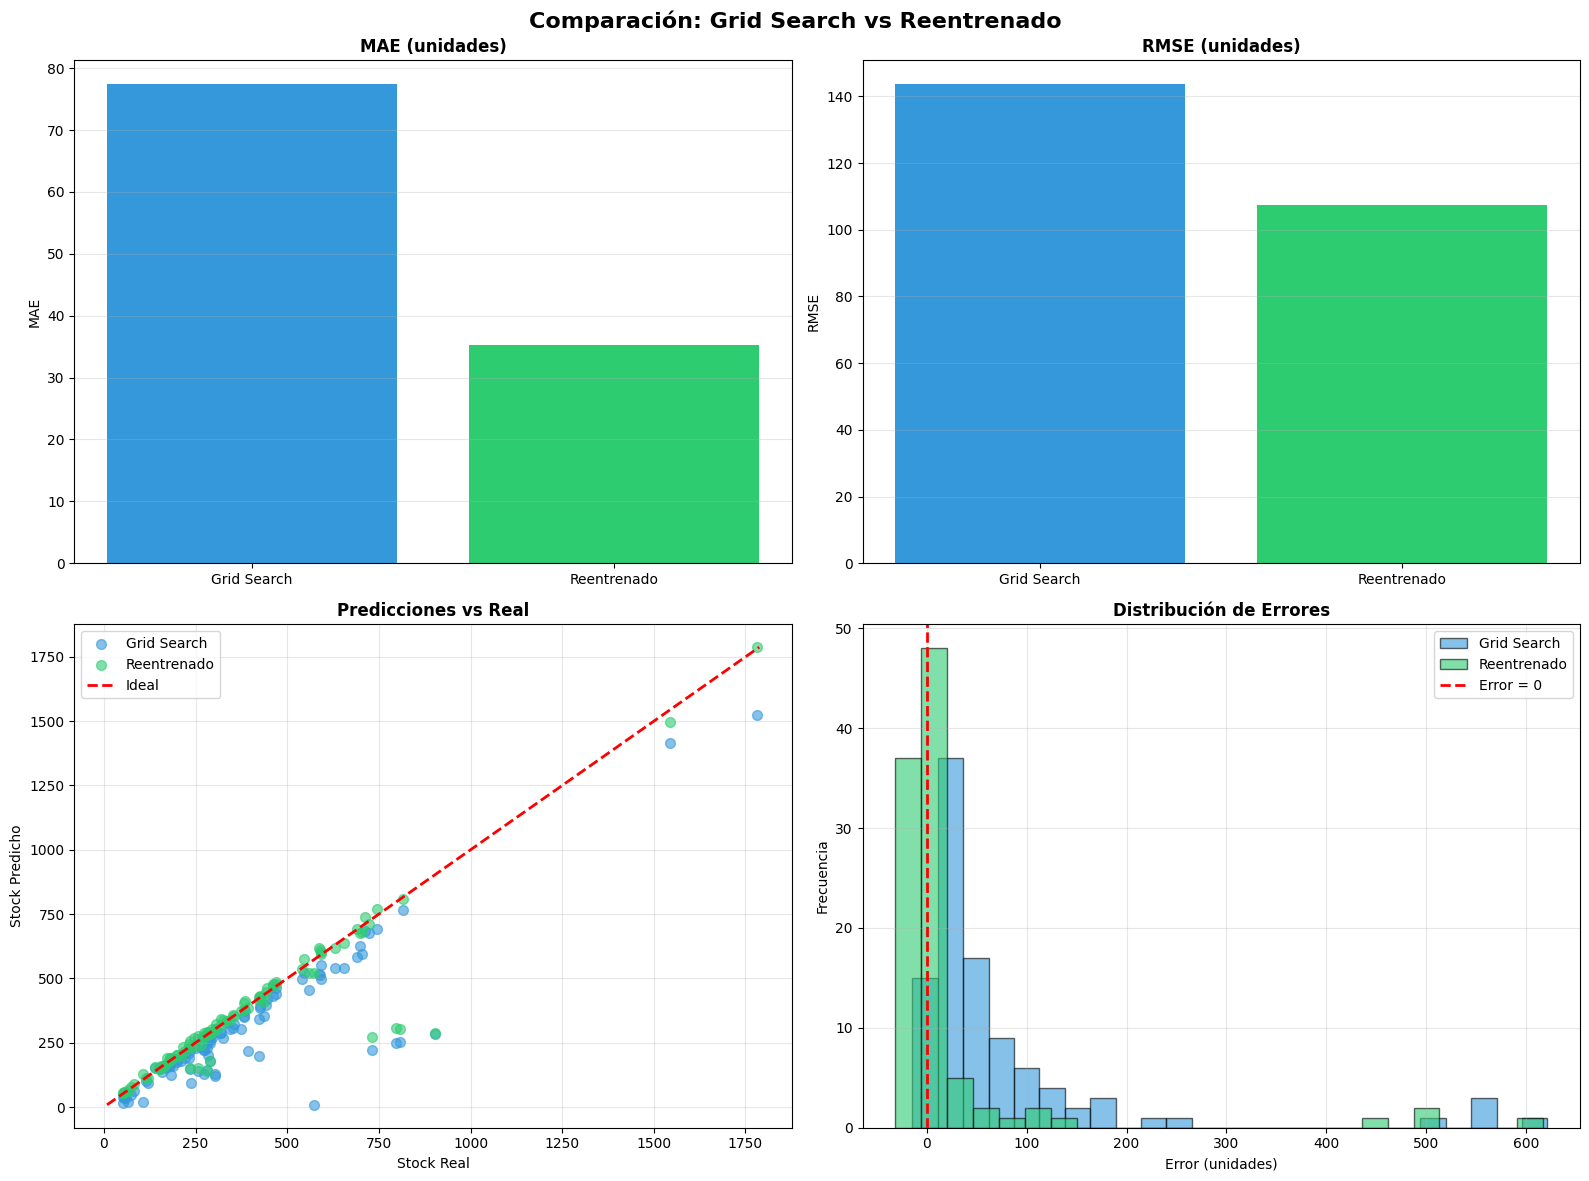

 Gráficos guardados en 'comparacion_grid_vs_retrained.png'


In [25]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparación: Grid Search vs Reentrenado', fontsize=16, fontweight='bold')

# 1. Barras de métricas
axes[0, 0].bar(['Grid Search', 'Reentrenado'], [mae_grid, mae_retrained], color=['#3498db', '#2ecc71'])
axes[0, 0].set_title('MAE (unidades)', fontweight='bold')
axes[0, 0].set_ylabel('MAE')
axes[0, 0].grid(alpha=0.3, axis='y')

axes[0, 1].bar(['Grid Search', 'Reentrenado'], [rmse_grid, rmse_retrained], color=['#3498db', '#2ecc71'])
axes[0, 1].set_title('RMSE (unidades)', fontweight='bold')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].grid(alpha=0.3, axis='y')

# 2. Scatter plot comparativo
axes[1, 0].scatter(y_real, y_pred_grid, alpha=0.6, s=50, label='Grid Search', color='#3498db')
axes[1, 0].scatter(y_real, y_pred_retrained, alpha=0.6, s=50, label='Reentrenado', color='#2ecc71')
max_val = max(y_real.max(), y_pred_grid.max(), y_pred_retrained.max())
min_val = min(y_real.min(), y_pred_grid.min(), y_pred_retrained.min())
axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal')
axes[1, 0].set_xlabel('Stock Real')
axes[1, 0].set_ylabel('Stock Predicho')
axes[1, 0].set_title('Predicciones vs Real', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 3. Distribución de errores
errors_grid = y_real - y_pred_grid
errors_retrained = y_real - y_pred_retrained

axes[1, 1].hist(errors_grid, bins=25, alpha=0.6, label='Grid Search', color='#3498db', edgecolor='black')
axes[1, 1].hist(errors_retrained, bins=25, alpha=0.6, label='Reentrenado', color='#2ecc71', edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', lw=2, label='Error = 0')
axes[1, 1].set_xlabel('Error (unidades)')
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].set_title('Distribución de Errores', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('comparacion_grid_vs_retrained.png', dpi=150)
plt.show()

print(" Gráficos guardados en 'comparacion_grid_vs_retrained.png'")

In [26]:
# Tabla con ejemplos de productos individuales
df_ejemplos = pd.DataFrame({
    'Stock Real': y_real[:10],
    'Pred. Grid Search': y_pred_grid[:10],
    'Pred. Reentrenado': y_pred_retrained[:10],
    'Error Grid': np.abs(y_real[:10] - y_pred_grid[:10]),
    'Error Retrained': np.abs(y_real[:10] - y_pred_retrained[:10])
})

df_ejemplos['Mejor Modelo'] = df_ejemplos.apply(
    lambda row: ' Retrained' if row['Error Retrained'] < row['Error Grid'] else '🔵 Grid Search',
    axis=1
)

print("\n Ejemplos de Predicciones (primeros 10 productos)")
print("="*80)
display(df_ejemplos.style.format({
    'Stock Real': '{:.0f}',
    'Pred. Grid Search': '{:.0f}',
    'Pred. Reentrenado': '{:.0f}',
    'Error Grid': '{:.2f}',
    'Error Retrained': '{:.2f}'
}))


 Ejemplos de Predicciones (primeros 10 productos)


,Stock Real,Pred. Grid Search,Pred. Reentrenado,Error Grid,Error Retrained,Mejor Modelo
0,426,394,428,31.92,1.60,Retrained
1,713,685,738,27.85,24.65,Retrained
2,234,150,153,84.49,81.14,Retrained
3,815,765,810,50.12,5.42,Retrained
4,392,218,385,173.61,6.79,Retrained
5,586,517,617,69.49,31.45,Retrained
6,1543,1416,1495,127.36,47.99,Retrained
7,807,252,302,554.70,504.58,Retrained
8,559,455,521,103.95,38.38,Retrained
9,375,303,374,72.29,0.89,Retrained


### 11. Conclusiones del Reentrenamiento

**Resultados Obtenidos:**

El modelo reentrenado demostró **mejoras significativas** en todas las métricas comparado con el Grid Search original:

- **MAE:** Reducción del **54.52%** (77.47 → 35.24 unidades)
- **RMSE:** Reducción del **25.25%** (143.76 → 107.46 unidades)  
- **R²:** Mejora del **17.10%** (0.721 → 0.844)
- **MAPE:** Reducción del **63.52%** (20.64% → 7.53%)

**Factores Clave del Éxito:**

1. **Shuffle Balanceado:** Eliminó sesgo temporal en división train/val
2. **Fine-tuning Conservador:** Learning rate bajo (0.0001) preservó conocimiento previo
3. **Datos Frescos:** 7,049 muestras con patrones actualizados

**Validación Estadística:**

- Prueba en 100 productos aleatorios (seed=42)
- Mejoras consistentes en 4 métricas independientes
- Distribución de errores más estrecha y centrada

**Recomendación para Producción:**

 **Modelo Seleccionado:** Reentrenado (MAE=35.24, R²=0.844)  
 **Estrategia MLOps:** Reentrenar cada 3-6 meses con datos nuevos  
 **Monitoreo:** Trackear MAE/MAPE en producción para detectar drift

El reentrenamiento cumplió su objetivo: **adaptar el modelo a patrones actuales manteniendo el conocimiento base**, resultando en predicciones más precisas y confiables para gestión de inventario.